# Analyse des flux RSS - InsightDetector

Ce notebook effectue une analyse complète des articles collectés depuis les flux RSS configurés.

## Sommaire

1. [Configuration et imports](#1-configuration-et-imports)
2. [Collecte des données](#2-collecte-des-données) 
3. [Traitement et stockage](#3-traitement-et-stockage)
4. [Analyses statistiques de base](#4-analyses-statistiques-de-base)
5. [Analyses temporelles avancées](#5-analyses-temporelles-avancées)
6. [Analyse des mots-clés et contenus](#6-analyse-des-mots-clés-et-contenus)
7. [Visualisations interactives](#7-visualisations-interactives)
8. [Métriques de qualité](#8-métriques-de-qualité)
9. [Conclusions et recommandations](#9-conclusions-et-recommandations)

---

## 1. Configuration et imports



In [1]:
# Auto-reload des modules modifiés (pratique pour développement)
%load_ext autoreload
%autoreload 2

# Imports standards
import sys
from pathlib import Path

# Définition du répertoire racine du projet 
project_root = Path().resolve().parents[1] if "notebooks" in str(Path().resolve()) else Path().resolve()

# Définition des chemins utilisés
src_dir = project_root / "src"
data_dir = project_root / "data"
outputs_dir = project_root / "outputs"
notebooks_dir = project_root / "notebooks"

# Création des dossiers s'ils n'existent pas
for d in [data_dir, outputs_dir]:
    d.mkdir(parents=True, exist_ok=True)

# 
src_path = str(src_dir.resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)




In [2]:
# Imports principaux
from data.rss_collector import RSSCollector
from data.article_parser import ArticleParser
from data.database_manager import DatabaseManager
from config.database import SessionLocal

import pandas as pd
import numpy as np
import time
import logging
from datetime import datetime, timedelta
import warnings
from collections import Counter
import re

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


DATABASE_URL détecté : sqlite:///data/insight.db


In [3]:

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Charger .env
load_dotenv(dotenv_path="../../.env")  # adapte le chemin si besoin

# Récupérer la vraie DATABASE_URL
db_url = os.getenv("DATABASE_URL")
if db_url is None:
    raise ValueError("DATABASE_URL manquant dans le fichier .env")

# Création moteur SQLAlchemy
connect_args = {"check_same_thread": False} if db_url.startswith("sqlite") else {}
engine = create_engine(db_url, connect_args=connect_args)

# Test connexion
with engine.connect() as conn:
    print(f"Connexion réussie à la base : {db_url}")


Connexion réussie à la base : sqlite:///data/insight.db


In [4]:
# Pour accéder au dossier src/ depuis le notebook
import sys
sys.path.append(".")

# Importation des composants ORM
from config.database import engine
from data.models import Base

# Création des tables dans la base PostgreSQL
Base.metadata.create_all(bind=engine)



In [5]:
from sqlalchemy import text

with engine.connect() as conn:
    result = conn.execute(
        text("SELECT name FROM sqlite_master WHERE type='table';")  # pour SQLite
    )
    print("Tables dans la base de données :")
    for row in result:
        print("  →", row[0])
        


Tables dans la base de données :
  → articles


In [6]:
# Installation et imports avec gestion d'erreurs
import sys
import subprocess
import importlib

# Function pour installer les packages manquants
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Liste des packages requis
required_packages = [
    "lxml_html_clean",
    "pandas", 
    "matplotlib", 
    "seaborn", 
    "plotly", 
    "feedparser",
    "beautifulsoup4"
]

# Installer les packages manquants
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        print(f"Installation de {package}...")
        try:
            install_package(package)
        except:
            print(f"Impossible d'installer {package}")

# Imports principaux avec gestion d'erreur
try:
    import sys
    sys.path.append('C:/Users/beedi.goua_square-ma/Desktop/Gheb/projet perso/InsightDetector/insight-detector/src')
    
    from data.rss_collector import RSSCollector
    from data.article_parser import ArticleParser
    from data.database_manager import DatabaseManager
    from config.database import SessionLocal
except ImportError as e:
    print(f"Erreur d'import modules projet: {e}")
    print(" Vérifiez que vous êtes dans le bon répertoire et que les modules existent")


Installation de beautifulsoup4...


In [7]:

import pandas as pd
import numpy as np
import time
import logging
from datetime import datetime, timedelta
import warnings
from collections import Counter
import re

# Visualisation (avec gestion d'erreurs)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
    
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    plotly_available = True
except ImportError:
    print("Plotly non disponible - visualisations interactives désactivées")
    plotly_available = False

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configuration logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Flux RSS utilisés
RSS_SOURCES = [
    "https://www.lemonde.fr/rss/une.xml",
    "https://www.france24.com/fr/rss", 
    "https://www.rfi.fr/fr/rss",
    "https://www.lexpress.fr/rss/actualite.xml",
    "https://www.courrierinternational.com/feed/all/rss.xml",
    "https://www.nouvelobs.com/rss.xml",
    "https://www.lesechos.fr/rss/rss_une.xml",
    "https://www.euronews.com/rss?level=theme&name=news",
    "https://www.huffingtonpost.fr/feeds/index.xml",
    "https://rss.nytimes.com/services/xml/rss/nyt/World.xml"
]

print("Configuration et imports terminés")
print(f" Plotly disponible: {'Oui' if plotly_available else 'Non'}")
print(f"  Sources RSS configurées: {len(RSS_SOURCES)}")

Configuration et imports terminés
 Plotly disponible: Oui
  Sources RSS configurées: 10


In [8]:
# Initialisation des composants avec gestion d'erreurs
session = None
collector = None
parser = None
db = None

try:
    collector = RSSCollector(RSS_SOURCES)
    parser = ArticleParser()
    session = SessionLocal()
    db = DatabaseManager(session)
    logger.info("Composants initialisés avec succès")
    
    # Variables pour tracking des métriques
    metrics = {
        'sources_success': {},
        'sources_errors': {},
        'total_fetched': 0,
        'total_processed': 0,
        'total_inserted': 0,
        'total_duplicates': 0,
        'processing_errors': []
    }
    
except Exception as e:
    logger.error(f"Erreur lors de l'initialisation: {e}")
    if session:
        session.close()
    raise

2025-07-23 19:48:57,138 - INFO - Composants initialisés avec succès


## 2. Collecte des données

Initialisation des composants et collecte des articles depuis les flux RSS configurés.

In [9]:
# Collecte robuste des articles avec métriques détaillées
articles = []
start_time = time.time()

try:
    logger.info("Début de la collecte des flux RSS...")
    articles = collector.fetch_feeds()
    metrics['total_fetched'] = len(articles)
    
    # Analyse des sources par succès/échec
    for article in articles:
        source = article.get('source', 'Unknown')
        metrics['sources_success'][source] = metrics['sources_success'].get(source, 0) + 1
    
    collection_time = time.time() - start_time
    
    logger.info(f"{len(articles)} articles collectés en {collection_time:.2f}s")
    print(f"Résumé de la collecte:")
    print(f"   • Total articles: {len(articles)}")
    print(f"   • Temps de collecte: {collection_time:.2f}s")
    print(f"   • Articles par seconde: {len(articles)/collection_time:.1f}")
    
    # Affichage par source
    if articles:
        print("\nArticles par source:")
        for source, count in sorted(metrics['sources_success'].items(), key=lambda x: x[1], reverse=True):
            print(f"   • {source}: {count} articles")
    
except Exception as e:
    logger.error(f"Erreur lors de la collecte: {e}")
    metrics['processing_errors'].append(f"Collecte: {str(e)}")
    print(f"Échec de la collecte: {e}")

2025-07-23 19:48:57,337 - INFO - Début de la collecte des flux RSS...
2025-07-23 19:48:57,339 - INFO - Lecture du flux RSS : https://www.lemonde.fr/rss/une.xml
2025-07-23 19:48:57,759 - INFO - Lecture du flux RSS : https://www.france24.com/fr/rss
2025-07-23 19:48:58,110 - INFO - Lecture du flux RSS : https://www.rfi.fr/fr/rss
2025-07-23 19:48:58,557 - INFO - Lecture du flux RSS : https://www.lexpress.fr/rss/actualite.xml
2025-07-23 19:48:59,942 - INFO - Lecture du flux RSS : https://www.courrierinternational.com/feed/all/rss.xml
2025-07-23 19:49:00,446 - INFO - Lecture du flux RSS : https://www.nouvelobs.com/rss.xml
2025-07-23 19:49:00,951 - INFO - Lecture du flux RSS : https://www.lesechos.fr/rss/rss_une.xml
2025-07-23 19:49:01,252 - INFO - Lecture du flux RSS : https://www.euronews.com/rss?level=theme&name=news
2025-07-23 19:49:01,638 - INFO - Lecture du flux RSS : https://www.huffingtonpost.fr/feeds/index.xml
2025-07-23 19:49:02,277 - INFO - Lecture du flux RSS : https://rss.nytimes

Résumé de la collecte:
   • Total articles: 510
   • Temps de collecte: 5.39s
   • Articles par seconde: 94.7

Articles par source:
   • https://www.nouvelobs.com/rss.xml: 200 articles
   • https://www.lexpress.fr/rss/actualite.xml: 100 articles
   • https://rss.nytimes.com/services/xml/rss/nyt/World.xml: 55 articles
   • https://www.euronews.com/rss?level=theme&name=news: 50 articles
   • https://www.rfi.fr/fr/rss: 24 articles
   • https://www.france24.com/fr/rss: 23 articles
   • https://www.courrierinternational.com/feed/all/rss.xml: 20 articles
   • https://www.huffingtonpost.fr/feeds/index.xml: 20 articles
   • https://www.lemonde.fr/rss/une.xml: 18 articles


In [10]:
# Traitement optimisé des articles avec métriques détaillées
processed = []
processing_start = time.time()

if articles:
    logger.info(f"Début du traitement de {len(articles)} articles...")
    
    for i, article in enumerate(articles, 1):
        try:
            # Extraction du texte avec timeout
            start_extract = time.time()
            article["text"] = parser.extract_text(article["url"])
            extract_time = time.time() - start_extract
            
            if not article["text"] or len(article["text"]) < 100:
                logger.debug(f"Article {i}: texte trop court ou vide ({article.get('url', 'URL inconnue')})")
                continue
            
            # Tentative d'insertion en base
            try:
                db.create_article(article)
                metrics['total_inserted'] += 1
                processed.append(article)
                logger.debug(f"Article {i}: inséré avec succès (extraction: {extract_time:.2f}s)")
                
            except Exception as db_error:
                if "UNIQUE constraint failed" in str(db_error) or "duplicate key" in str(db_error):
                    metrics['total_duplicates'] += 1
                    logger.debug(f"Article {i}: doublons détecté")
                else:
                    error_msg = f"Insertion article {i}: {str(db_error)}"
                    metrics['processing_errors'].append(error_msg)
                    logger.warning(error_msg)
            
            metrics['total_processed'] += 1
            
            # Pause adaptative pour éviter la surcharge
            time.sleep(0.1 if i % 10 != 0 else 0.3)
            
            # Progress indicator
            if i % 10 == 0 or i == len(articles):
                progress = (i / len(articles)) * 100
                print(f"Progression: {i}/{len(articles)} ({progress:.1f}%) - "
                      f"Insérés: {metrics['total_inserted']}, "
                      f"Doublons: {metrics['total_duplicates']}")
                
        except Exception as e:
            error_msg = f"Erreur traitement article {i}: {str(e)}"
            metrics['processing_errors'].append(error_msg)
            logger.error(error_msg)
            continue

processing_time = time.time() - processing_start

# Résumé final
print(f"\nRésumé du traitement:")
print(f"   • Articles traités: {metrics['total_processed']}/{len(articles)}")
print(f"   • Articles insérés: {metrics['total_inserted']}")
print(f"   • Doublons détectés: {metrics['total_duplicates']}")
print(f"   • Erreurs: {len(metrics['processing_errors'])}")
print(f"   • Temps total: {processing_time:.2f}s")
print(f"   • Taux de succès: {(metrics['total_inserted']/len(articles)*100):.1f}%")

if metrics['processing_errors']:
    print(f"\nDernières erreurs:")
    for error in metrics['processing_errors'][-3:]:  # Affiche les 3 dernières erreurs
        print(f"   • {error}")
        
logger.info(f"Traitement terminé: {metrics['total_inserted']} articles insérés")

2025-07-23 19:49:03,126 - INFO - Début du traitement de 510 articles...
2025-07-23 19:49:03,127 - INFO - Téléchargement de l'article : https://www.lemonde.fr/international/live/2025/07/23/en-direct-gaza-une-grande-proportion-des-habitants-de-l-enclave-meurt-de-faim-selon-le-chef-de-l-oms_6622839_3210.html
2025-07-23 19:49:04,349 - INFO - Téléchargement de l'article : https://www.lemonde.fr/planete/article/2025/07/23/le-changement-climatique-est-une-menace-urgente-et-existentielle-declare-la-cij-dans-un-avis-historique_6623222_3244.html
2025-07-23 19:49:04,914 - INFO - Téléchargement de l'article : https://www.lemonde.fr/politique/article/2025/07/23/l-emploi-des-seniors-atteint-un-niveau-record-en-2024_6623248_823448.html
2025-07-23 19:49:06,034 - INFO - Téléchargement de l'article : https://www.lemonde.fr/international/article/2025/07/23/un-sommet-ue-chine-sous-le-signe-de-la-discorde_6623249_3210.html
2025-07-23 19:49:06,627 - INFO - Téléchargement de l'article : https://www.lemonde.f

Progression: 10/510 (2.0%) - Insérés: 10, Doublons: 0


2025-07-23 19:49:12,345 - INFO - Téléchargement de l'article : https://www.lemonde.fr/societe/article/2025/07/23/kurdes-tues-a-paris-william-malet-renvoye-aux-assises-pour-assassinats-racistes-mais-pas-terroristes_6623259_3224.html
2025-07-23 19:49:12,934 - INFO - Téléchargement de l'article : https://www.lemonde.fr/international/article/2025/07/23/a-mi-mandat-la-legislature-espagnole-bloquee_6623254_3210.html
2025-07-23 19:49:13,572 - INFO - Téléchargement de l'article : https://www.lemonde.fr/economie/article/2025/07/23/le-relais-reprend-la-collecte-des-vetements-de-seconde-main-apres-l-annonce-d-une-revalorisation-de-la-retribution-des-operateurs-du-tri_6623243_3234.html
2025-07-23 19:49:14,135 - INFO - Téléchargement de l'article : https://www.lemonde.fr/economie/article/2025/07/23/droits-de-douane-pourquoi-le-japon-se-satisfait-d-une-taxe-de-15-avec-les-etats-unis_6623241_3234.html
2025-07-23 19:49:14,679 - INFO - Téléchargement de l'article : https://www.lemonde.fr/economie/artic

Progression: 20/510 (3.9%) - Insérés: 20, Doublons: 0


2025-07-23 19:49:19,576 - WARNING - Article trop court ou vide : https://www.france24.com/fr/vid%C3%A9o/20250723-la-cour-internationale-de-justice-ouvre-la-voie-aux-r%C3%A9parations-climatiques
2025-07-23 19:49:19,580 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-n%C3%A9gociations-ukraine-russie-des-positions-irr%C3%A9conciliables
2025-07-23 19:49:20,197 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-l-union-europ%C3%A9enne-demande-des-explications-%C3%A0-zelensky-concernant-la-lutte-anticorruption
2025-07-23 19:49:20,680 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-que-demandent-les-russes-et-les-ukrainiens-aux-n%C3%A9gociations-%C3%A0-istanbul
2025-07-23 19:49:21,267 - INFO - Téléchargement de l'article : https://www.france24.com/fr/sports/20250723-tour-de-france-jonathan-milan-remporte-au-sprint-la-17e-%C3%A9tape-et-et-pr%C3%A9serve-son-maillot-vert-pogacar
2025

Progression: 30/510 (5.9%) - Insérés: 26, Doublons: 0


2025-07-23 19:49:24,891 - WARNING - Article trop court ou vide : https://www.france24.com/fr/vid%C3%A9o/20250723-larmes-de-joie-au-venezuela-au-retour-de-migrants-lib%C3%A9r%C3%A9s-de-prison
2025-07-23 19:49:24,892 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-%C3%A9tats-unis-la-vid%C3%A9o-d-un-policier-frappant-un-homme-noir-suscite-l-indignation
2025-07-23 19:49:25,290 - WARNING - Article trop court ou vide : https://www.france24.com/fr/vid%C3%A9o/20250723-%C3%A9tats-unis-la-vid%C3%A9o-d-un-policier-frappant-un-homme-noir-suscite-l-indignation
2025-07-23 19:49:25,290 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-trump-annonce-un-accord-commerical-%C3%A9norme-avec-le-japon
2025-07-23 19:49:25,828 - INFO - Téléchargement de l'article : https://www.france24.com/fr/vid%C3%A9o/20250723-guerre-en-ukraine-troisi%C3%A8me-round-de-n%C3%A9gociations-avec-la-russie-en-turquie
2025-07-23 19:49:26,291 - INFO - Téléc

Progression: 40/510 (7.8%) - Insérés: 34, Doublons: 0


2025-07-23 19:49:29,997 - WARNING - Article trop court ou vide : https://www.france24.com/fr/vid%C3%A9o/20250723-%C3%A0-tel-aviv-des-isra%C3%A9liens-manifestent-pour-d%C3%A9noncer-la-famine-%C3%A0-gaza
2025-07-23 19:49:29,999 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/europe/20250723-ukraine-toll%C3%A9-apr%C3%A8s-l-adoption-d-une-loi-qui-supprime-l-ind%C3%A9pendance-des-agences-anticorruption
2025-07-23 19:49:30,590 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/asie-pacifique/20250723-un-sommet-ue-chine-dans-un-climat-de-tensions-commerciales-et-g%C3%A9opolitiques
2025-07-23 19:49:31,092 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/france/20250723-perquisition-au-si%C3%A8ge-de-l-office-anti-stup%C3%A9fiants-%C3%A0-nanterre-dans-le-cadre-d-un-trafic-de-coca%C3%AFne
2025-07-23 19:49:31,548 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/sports/20250723-tour-de-france-2025-l-italien-jonathan-milan-s-impose-%C3%A0-valence-pour-s

Progression: 50/510 (9.8%) - Insérés: 43, Doublons: 0


2025-07-23 19:49:36,083 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/afrique/20250723-congo-brazzaville-saison-pluies-froid-inhabituel-habitants-climat-rarement-fra%C3%AEche
2025-07-23 19:49:36,675 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/france/20250723-france-la-justice-ordonne-un-proc%C3%A8s-pour-corruption-contre-rachida-dati-la-ministre-attaque-les-magistrats
2025-07-23 19:49:37,272 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/culture/20250723-les-chor%C3%A9graphes-tunisiens-selma-et-sofiane-ouissi-en-un-mot-un-geste-et-un-silence
2025-07-23 19:49:37,887 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/culture/20250723-avignon-2025-laaroussa-quartet-le-corps-libre-des-femmes-poti%C3%A8res-en-tunisie
2025-07-23 19:49:38,431 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/moyen-orient/20250723-gaza-71-000-enfants-risquent-mourir-malnutrition-aigu%C3%AB-alerte-unicef-baptiste-chapuis
2025-07-23 19:49:38,985 

Progression: 60/510 (11.8%) - Insérés: 53, Doublons: 0


2025-07-23 19:49:41,921 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/sports/20250723-mma-ciryl-gane-affrontera-tom-aspinall-en-octobre-pour-la-ceinture-des-poids-lourds
2025-07-23 19:49:42,467 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/sports/20250723-sport-l-activit%C3%A9-physique-peut-elle-aider-%C3%A0-pr%C3%A9venir-les-calculs-r%C3%A9naux
2025-07-23 19:49:42,950 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/afrique/20250723-le-nigeria-r%C3%A9vise-son-pib-%C3%A0-la-hausse-de-30-en-2024-apr%C3%A8s-l-int%C3%A9gration-de-nouveaux-secteurs
2025-07-23 19:49:43,477 - INFO - Téléchargement de l'article : https://www.rfi.fr/fr/afrique/20250723-guin%C3%A9e-conakry-reprend-contr%C3%B4le-transport-bauxite-maximiser-revenus-m%C3%A9taux-mines-min%C3%A9rais-%C3%A9conomie-exportation
2025-07-23 19:49:43,989 - INFO - Téléchargement de l'article : https://www.lexpress.fr/idees-et-debats/loi-duplomb-linstrumentalisation-des-ecologistes-radicaux-coute-ch

Progression: 70/510 (13.7%) - Insérés: 63, Doublons: 0


2025-07-23 19:49:47,420 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/incendies-explosions-liran-victime-dune-campagne-de-sabotage-israelienne-HYAQ5PECTVHYHGFNXNROZ6I3YU/
2025-07-23 19:49:47,898 - INFO - Téléchargement de l'article : https://www.lexpress.fr/sciences-sante/lutte-contre-lobesite-wegovy-et-mounjaro-vont-ils-tuer-la-prevention-G2XU2IBZOFCJRN5UGXLROHOF7E/
2025-07-23 19:49:48,523 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/bruno-retailleau-contre-emmanuel-macron-gare-au-syndrome-du-vilain-petit-canard-YBX2WLQ75VGMHJOKIMDZXQ3VNI/
2025-07-23 19:49:49,041 - INFO - Téléchargement de l'article : https://www.lexpress.fr/societe/le-general-fabien-mandon-nomme-chef-detat-major-des-armees-francaises-22LC6O34HVE4PEAKZCRCDFE2OU/
2025-07-23 19:49:49,507 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/afrique/tensions-avec-lalgerie-bruno-retailleau-durcit-encore-le-ton-SGMPBRL2SJF75CVBCKW33MY2DI/

Progression: 80/510 (15.7%) - Insérés: 72, Doublons: 0


2025-07-23 19:49:54,146 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/francois-de-rugy-sur-la-loi-duplomb-cette-petition-est-le-degre-01-du-soulevement-populaire-O67UYM3ALZHFVEBCUSGKIIBNX4/
2025-07-23 19:49:54,690 - INFO - Téléchargement de l'article : https://www.lexpress.fr/societe/cinema-ce-succes-tres-discret-qui-en-dit-long-sur-la-france-par-anne-rosencher-ETPXNROVNFA5NAZDWIWCXFICRI/
2025-07-23 19:49:55,210 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/le-macronisme-sachevera-avec-emmanuel-macron-bruno-retailleau-provoque-un-nouveau-tolle-UJJY65RZVFBVTODXUKB2LOAH2Q/
2025-07-23 19:49:55,822 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/droits-de-douane-de-donald-trump-le-japon-echappe-a-des-surtaxes-de-25-II2Y4VDH4FGK3DKNFB4PDBW554/
2025-07-23 19:49:56,336 - INFO - Téléchargement de l'article : https://www.lexpress.fr/culture/au-centre-pompidou-lanarchie-photographique-de-wolfgang-tillmans-NT4PRPJHJVHCX

Progression: 90/510 (17.6%) - Insérés: 82, Doublons: 0


2025-07-23 19:50:00,363 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/droits-de-douane-de-donald-trump-cette-autre-menace-americaine-qui-plane-sur-la-chine-VSTNVJDOSZEA3K2LANCC3NURZM/
2025-07-23 19:50:01,578 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/europe/guerre-en-ukraine-ce-que-lon-sait-des-nouveaux-pourparlers-prevus-en-turquie-ce-mercredi-WW4YQKOX45AC5NLBFE2CRG2PA4/
2025-07-23 19:50:02,069 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/europe/espagne-derriere-la-fievre-anti-immigres-des-relais-extremistes-bases-a-letranger-HJXRFHBAQBHOLDTZLMKCZPUXQU/
2025-07-23 19:50:02,553 - INFO - Téléchargement de l'article : https://www.lexpress.fr/sciences-sante/a-quoi-ressembleront-les-regimes-de-demain-les-previsions-de-la-nutritionniste-americaine-holly-TTX5WQPEWFASXHL7FKA2SLUUXQ/
2025-07-23 19:50:03,125 - INFO - Téléchargement de l'article : https://www.lexpress.fr/societe/justice/affaire-renault-nissan-rachida-dat

Progression: 100/510 (19.6%) - Insérés: 92, Doublons: 0


2025-07-23 19:50:06,694 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/georges-ibrahim-abdallah-ne-doit-pas-sa-liberation-a-ses-soutiens-tres-politiques-par-jean-marc-IAA2JPKNLBHHZCPWZPAVIUZ27Y/
2025-07-23 19:50:07,244 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/emploi/management/pourquoi-prendre-lascenseur-au-travail-nous-met-il-autant-mal-a-laise-UNTISWDDVJAN5NEUTJJAPRKDZE/
2025-07-23 19:50:07,804 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/politique-economique/avec-ou-sans-loi-duplomb-lagriculture-francaise-se-meurt-AGPZQK4MCFDJ3JMAOVNDGQXOJA/
2025-07-23 19:50:08,340 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/recherches-extremistes-traque-aux-vpn-en-russie-les-internautes-toujours-plus-surveilles-NI6ZUDVCXVBLTFYD7L4X4M4U44/
2025-07-23 19:50:08,885 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/lr/rachida-dati-face-a-michel-barnier-a-paris-le-poison-du

Progression: 110/510 (21.6%) - Insérés: 102, Doublons: 0


2025-07-23 19:50:12,386 - INFO - Téléchargement de l'article : https://www.lexpress.fr/societe/justice/accusations-dingerence-etrangere-le-reseau-x-soppose-a-la-justice-francaise-WADY7EU7FVF4JGYEDYKXPQ3UUY/
2025-07-23 19:50:12,853 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/europe/depuis-1945-jamais-les-enfants-nont-autant-souffert-de-la-guerre-lalerte-de-la-presidente-dunicef-AO6KC2KPP5C5HODB4YBB53IBCU/
2025-07-23 19:50:13,453 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/apres-le-madleen-le-handala-ce-que-lon-sait-du-nouveau-navire-en-route-pour-gaza-N2NHPB6PNFDYBFJCVCHXXPBJS4/
2025-07-23 19:50:14,053 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/gaza-israel-etend-ses-operations-terrestres-dans-une-nouvelle-zone-au-centre-du-territoire-FKDEYGC2YRBVLI7E36FT4ATAD4/
2025-07-23 19:50:15,775 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/

Progression: 120/510 (23.5%) - Insérés: 112, Doublons: 0


2025-07-23 19:50:19,111 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/quel-avenir-pour-la-loi-duplomb-quatre-questions-apres-le-succes-inedit-de-la-petition-contre-le-NLNARHBPJVFQJL7WOWXRRX5WCU/
2025-07-23 19:50:19,683 - INFO - Téléchargement de l'article : https://www.lexpress.fr/idees-et-debats/la-grande-arnaque-des-livres-de-developpement-personnel-a-la-plage-par-julia-de-funes-IVHZBPZ2TJBKBGWT4PZZFKKGAE/
2025-07-23 19:50:20,196 - INFO - Téléchargement de l'article : https://www.lexpress.fr/idees-et-debats/vladimir-poutine-et-le-sexe-du-male-alpha-obscene-au-patriarche-conservateur-ADLSZV36URCUXB4FDAVLZUI5Z4/
2025-07-23 19:50:20,731 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/politique-economique/ecoles-abandonnees-casernes-desaffectees-la-verite-sur-la-gestion-immobiliere-de-letat-FD6TL3GGURF3ZIN6ASCPRWR6F4/
2025-07-23 19:50:21,309 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/dette-ces-hedge-funds-qui

Progression: 130/510 (25.5%) - Insérés: 122, Doublons: 0


2025-07-23 19:50:25,547 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/asie/terres-rares-face-aux-restrictions-a-lexportation-chinoise-les-fabricants-occidentaux-cherchent-des-RGPETSXCWVHHHFGQX4M2GRO2VU/
2025-07-23 19:50:26,110 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/emploi/management/les-tracances-nouveau-luxe-ou-piege-dore-des-cadres-par-caroline-diard-4ZMNSZCJC5FH3JFG4N4NAX2NPA/
2025-07-23 19:50:26,585 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/nucleaire-iranien-nouvelles-discussions-cette-semaine-avec-teheran-sous-la-menace-du-snapback-5EETN5B4I5ACVGBAIEYRZ36NXM/
2025-07-23 19:50:27,084 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/guerre-contre-israel-liran-dit-avoir-remplace-ses-systemes-antiaeriens-endommages-J6Z3VWLU4NBT7P5TJLCJ6EAJIU/
2025-07-23 19:50:27,532 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/asie/japon

Progression: 140/510 (27.5%) - Insérés: 132, Doublons: 0


2025-07-23 19:50:31,020 - INFO - Téléchargement de l'article : https://www.lexpress.fr/idees-et-debats/ben-chu-bbc-si-les-etats-unis-se-retirent-de-leconomie-mondiale-les-autres-pourraient-tenir-bon-PIT2WTECDNAQBFKSHGSCS2XG24/
2025-07-23 19:50:31,595 - INFO - Téléchargement de l'article : https://www.lexpress.fr/economie/entreprises/handilab-le-pari-du-business-au-service-du-handicap-WPPMTE6OAJGNLBQJIWQY7LFDM4/
2025-07-23 19:50:32,075 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/amerique/ils-multiplient-les-bebes-pour-sauver-lhumanite-aux-etats-unis-le-grand-retour-des-natalistes-R2HBF7L4UFAQNCYQO4IDUU2BMM/
2025-07-23 19:50:32,557 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/la-petition-dune-etudiante-pourrait-relancer-le-debat-sur-la-controversee-loi-duplomb-2BLNPRKZYJEGNLO4222OJPEZL4/
2025-07-23 19:50:33,036 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/syrie-les-entreprises-belliqueuses-is

Progression: 150/510 (29.4%) - Insérés: 142, Doublons: 0


2025-07-23 19:50:36,444 - INFO - Téléchargement de l'article : https://www.lexpress.fr/societe/les-festivals-francais-vont-ils-disparaitre-cette-crise-silencieuse-qui-menace-tout-un-modele-5LJAJ6UZXRHWVIBEXJMCXI47SA/
2025-07-23 19:50:36,962 - INFO - Téléchargement de l'article : https://www.lexpress.fr/culture/quand-chateaubriand-et-musset-ecrivaient-fashionables-ces-anglicismes-qui-ne-datent-pas-dhier-SLLHFFEANVF37J7UYQP2DHP7FY/
2025-07-23 19:50:37,502 - INFO - Téléchargement de l'article : https://www.lexpress.fr/culture/art/lannee-cezanne-a-aix-en-provence-un-reve-dart-au-jas-de-bouffan-T66YWKMCOREWPEHYIGZ6U5ASNU/
2025-07-23 19:50:38,112 - INFO - Téléchargement de l'article : https://www.lexpress.fr/argent/placements/bertrand-merveille-notre-epargne-est-progressivement-placee-sous-influence-americaine-7VAFLISSXJAVJO5WVK5TVZI4VA/
2025-07-23 19:50:38,722 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/entre-la-france-et-lalgerie-soixante-ans-de-guerres-despionnage

Progression: 160/510 (31.4%) - Insérés: 152, Doublons: 0


2025-07-23 19:50:42,447 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/proche-moyen-orient/syrie-le-cessez-le-feu-deja-menace-par-de-nouveaux-affrontements-JVDLKEAA5FETFPYPRJI2YYSGHY/
2025-07-23 19:50:42,980 - INFO - Téléchargement de l'article : https://www.lexpress.fr/politique/gestion-de-lelysee-sous-emmanuel-macron-la-cour-des-comptes-salue-des-progres-mais-74RIEP3AERFTFCLVTHB3YZKYTU/
2025-07-23 19:50:43,436 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/europe/espagne-comment-une-agression-a-ete-transformee-en-arme-de-desinformation-anti-immigration-VWFCF7CK25CBTFWLKY7I3CEABM/
2025-07-23 19:50:43,918 - INFO - Téléchargement de l'article : https://www.lexpress.fr/monde/europe/guerre-en-ukraine-lunion-europeenne-adopte-un-18e-paquet-de-sanctions-contre-la-russie-B7V7F7P67JAAPKP4CBJQQCF2DU/
2025-07-23 19:50:44,393 - INFO - Téléchargement de l'article : https://www.courrierinternational.com/article/economie-apres-l-accord-commercial-signe-av

Progression: 190/510 (37.3%) - Insérés: 161, Doublons: 0


2025-07-23 19:50:52,245 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/musique/20250723.OBS106158/que-marianne-etait-jolie-quand-michel-delpech-chante-une-certaine-idee-de-la-france-et-de-la-revolution.html
2025-07-23 19:50:52,852 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250723.OBS106157/moi-je-suis-fait-pour-les-tempetes-emmanuel-carrere-a-suivi-emmanuel-macron-dans-les-coulisses-du-g7.html
2025-07-23 19:50:53,425 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250723.OBS106156/les-coulisses-du-g7-racontees-par-emmanuel-carrere.html
2025-07-23 19:50:53,930 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/justice/20250723.OBS106155/pedocriminel-arrete-de-justesse-pres-d-orleans-c-est-vraiment-monsieur-tout-le-monde.html
2025-07-23 19:50:54,469 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/social/20250723.OBS106154/pourquoi-mal-travailler-coute-plus-cher-que-de-ne-pas-tr

Progression: 200/510 (39.2%) - Insérés: 169, Doublons: 0


2025-07-23 19:50:58,054 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/economie/20250723.OBS106147/qui-va-vraiment-payer-le-budget-bayrou-debat-entre-les-economistes-anne-sophie-alsif-et-henri-sterdyniak.html
2025-07-23 19:50:59,767 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/chroniques/20250723.OBS106146/j-ai-teste-pour-vous-le-bain-de-foret.html
2025-07-23 19:50:59,951 - ERROR - Échec parsing https://www.nouvelobs.com/chroniques/20250723.OBS106146/j-ai-teste-pour-vous-le-bain-de-foret.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/chroniques/20250723.OBS106146/j-ai-teste-pour-vous-le-bain-de-foret.html on URL https://www.nouvelobs.com/chroniques/20250723.OBS106146/j-ai-teste-pour-vous-le-bain-de-foret.html
2025-07-23 19:50:59,952 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250723.OBS106145/contre-l-hegemonie-culturelle-des-droites-dures-menons-une-batai

Progression: 210/510 (41.2%) - Insérés: 174, Doublons: 0


2025-07-23 19:51:02,908 - ERROR - Échec parsing https://www.nouvelobs.com/ecologie/20250722.OBS106138/interpol-leve-la-notice-rouge-visant-le-militant-ecologiste-paul-watson.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/ecologie/20250722.OBS106138/interpol-leve-la-notice-rouge-visant-le-militant-ecologiste-paul-watson.html on URL https://www.nouvelobs.com/ecologie/20250722.OBS106138/interpol-leve-la-notice-rouge-visant-le-militant-ecologiste-paul-watson.html
2025-07-23 19:51:02,909 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/societe/20250722.OBS106137/le-gouvernement-publie-une-feuille-de-route-pour-un-sommeil-de-qualite-pour-contrer-les-1h30-de-moins-par-nuit-en-50-ans.html
2025-07-23 19:51:03,431 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/culture/20250722.OBS106136/ozzy-osbourne-legende-du-heavy-metal-et-chanteur-de-black-sabbath-est-mort.html
2025-07-23 19:51:03,981 - INFO - Télé

Progression: 230/510 (45.1%) - Insérés: 180, Doublons: 0


2025-07-23 19:51:08,446 - ERROR - Échec parsing https://www.nouvelobs.com/tribunes/20250722.OBS106118/le-budget-bayrou-ne-repond-a-aucun-des-defis-majeurs-auxquels-la-france-fait-face.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/tribunes/20250722.OBS106118/le-budget-bayrou-ne-repond-a-aucun-des-defis-majeurs-auxquels-la-france-fait-face.html on URL https://www.nouvelobs.com/tribunes/20250722.OBS106118/le-budget-bayrou-ne-repond-a-aucun-des-defis-majeurs-auxquels-la-france-fait-face.html
2025-07-23 19:51:08,447 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/teleobs/20250722.OBS106115/en-tongs-au-pied-de-l-himalaya-audrey-lamy-en-mere-courage.html
2025-07-23 19:51:08,567 - ERROR - Échec parsing https://www.nouvelobs.com/teleobs/20250722.OBS106115/en-tongs-au-pied-de-l-himalaya-audrey-lamy-en-mere-courage.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.c

Progression: 240/510 (47.1%) - Insérés: 186, Doublons: 0


2025-07-23 19:51:12,733 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/medias/20250722.OBS106099/de-pulitzer-a-musk-la-democratie-a-toujours-ete-sous-influence-de-la-desinformation.html
2025-07-23 19:51:13,227 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/justice/20250722.OBS106098/mon-amour-j-ai-un-souci-il-me-faut-de-l-argent-comment-veronique-59-ans-a-ete-victime-d-arnaque-aux-sentiments.html
2025-07-23 19:51:13,924 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/monde/20250722.OBS106097/trump-et-l-affaire-epstein-ou-l-histoire-d-un-arroseur-arrose.html
2025-07-23 19:51:14,622 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/monde/20250721.OBS106096/guerre-en-ukraine-kiev-et-moscou-se-retrouveront-mercredi-en-turquie-pour-des-pourparlers.html
2025-07-23 19:51:15,350 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/medias/20250721.OBS106095/aucun-de-nous-n-a-le-souvenir-d-avoir-vu-un-collaborateur-m

Progression: 250/510 (49.0%) - Insérés: 194, Doublons: 0


2025-07-23 19:51:18,023 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250721.OBS106090/nous-malades-du-rein-prions-francois-bayrou-de-bien-vouloir-cesser-de-nous-faire-les-poches.html
2025-07-23 19:51:18,679 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/chroniques/20250721.OBS106089/le-bloc-notes-de-jerome-garcin-les-schneider-pere-et-fille.html
2025-07-23 19:51:19,213 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/teleobs/20250721.OBS106088/des-trains-pas-comme-les-autres-de-chicago-aux-rocheuses-la-vie-du-rail.html
2025-07-23 19:51:19,816 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/economie/20250721.OBS106087/pres-d-1-5-million-de-signatures-contre-la-loi-duplomb-face-au-naufrage-des-politiques-le-rebond-citoyen.html
2025-07-23 19:51:20,359 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/teleobs/20250721.OBS106086/la-ballade-des-sans-espoirs-beau-poetique-poignant.html
2025-07-23

Progression: 260/510 (51.0%) - Insérés: 203, Doublons: 0


2025-07-23 19:51:23,572 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/sciences/20250721.OBS106080/appendice-dents-de-sagesse-pourquoi-certaines-parties-de-notre-corps-sont-elles-inutiles.html
2025-07-23 19:51:24,076 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/tendances/20250721.OBS106079/le-congost-de-mont-rebei-une-randonnee-pour-defier-son-vertige.html
2025-07-23 19:51:24,191 - ERROR - Échec parsing https://www.nouvelobs.com/tendances/20250721.OBS106079/le-congost-de-mont-rebei-une-randonnee-pour-defier-son-vertige.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/tendances/20250721.OBS106079/le-congost-de-mont-rebei-une-randonnee-pour-defier-son-vertige.html on URL https://www.nouvelobs.com/tendances/20250721.OBS106079/le-congost-de-mont-rebei-une-randonnee-pour-defier-son-vertige.html
2025-07-23 19:51:24,191 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/202

Progression: 270/510 (52.9%) - Insérés: 210, Doublons: 0


2025-07-23 19:51:29,268 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250720.OBS106070/un-million-de-signatures-pour-la-petition-contre-la-loi-duplomb-cessez-le-feu-en-syrie-bayrou-et-son-budget-les-cinq-infos-a-retenir-du-week-end.html
2025-07-23 19:51:29,902 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/teleobs/20250720.OBS106069/dj-mehdi-made-in-france-un-beatmaker-incontournable.html
2025-07-23 19:51:30,057 - ERROR - Échec parsing https://www.nouvelobs.com/teleobs/20250720.OBS106069/dj-mehdi-made-in-france-un-beatmaker-incontournable.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/teleobs/20250720.OBS106069/dj-mehdi-made-in-france-un-beatmaker-incontournable.html on URL https://www.nouvelobs.com/teleobs/20250720.OBS106069/dj-mehdi-made-in-france-un-beatmaker-incontournable.html
2025-07-23 19:51:30,059 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/musique/

Progression: 350/510 (68.6%) - Insérés: 262, Doublons: 0


2025-07-23 19:52:04,673 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/justice/20250717.OBS105990/affaire-hedi-a-marseille-usage-disproportionne-de-la-force-responsabilite-de-la-hierarchie-ce-qu-il-faut-retenir-du-rapport-de-l-igpn.html
2025-07-23 19:52:04,847 - ERROR - Échec parsing https://www.nouvelobs.com/justice/20250717.OBS105990/affaire-hedi-a-marseille-usage-disproportionne-de-la-force-responsabilite-de-la-hierarchie-ce-qu-il-faut-retenir-du-rapport-de-l-igpn.html : Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.nouvelobs.com/justice/20250717.OBS105990/affaire-hedi-a-marseille-usage-disproportionne-de-la-force-responsabilite-de-la-hierarchie-ce-qu-il-faut-retenir-du-rapport-de-l-igpn.html on URL https://www.nouvelobs.com/justice/20250717.OBS105990/affaire-hedi-a-marseille-usage-disproportionne-de-la-force-responsabilite-de-la-hierarchie-ce-qu-il-faut-retenir-du-rapport-de-l-igpn.html
2025-07-23 19:52:04,848 - INFO - Télé

Progression: 380/510 (74.5%) - Insérés: 283, Doublons: 0


2025-07-23 19:52:20,373 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/idees/20250716.OBS105960/la-force-de-la-gentillesse.html
2025-07-23 19:52:20,961 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/politique/20250716.OBS105959/feries-supprimes-augmentations-d-impots-la-droite-et-les-macronistes-partagent-le-constat-de-bayrou-mais-pas-toutes-les-mesures.html
2025-07-23 19:52:21,596 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/monde/20250716.OBS105958/qui-est-julien-moinil-alias-batman-le-procureur-de-bruxelles-place-sous-protection-maximale.html
2025-07-23 19:52:22,182 - INFO - Téléchargement de l'article : https://www.nouvelobs.com/teleobs/20250716.OBS105957/evy-moi-echappee-belle.html
2025-07-23 19:52:22,740 - INFO - Téléchargement de l'article : https://www.euronews.com/2025/07/23/thailand-closes-some-border-crossings-with-cambodia-after-soldier-loses-leg-in-landmine-ex
2025-07-23 19:52:23,347 - INFO - Téléchargement de l'artic

Progression: 400/510 (78.4%) - Insérés: 299, Doublons: 0


2025-07-23 19:52:33,653 - WARNING - Article trop court ou vide : https://www.euronews.com/video/2025/07/23/kyiv-sees-rare-wartime-protest-over-anti-corruption-legislation
2025-07-23 19:52:33,653 - INFO - Téléchargement de l'article : https://www.euronews.com/video/2025/07/23/latest-news-bulletin-july-23rd-midday
2025-07-23 19:52:34,241 - WARNING - Article trop court ou vide : https://www.euronews.com/video/2025/07/23/latest-news-bulletin-july-23rd-midday
2025-07-23 19:52:34,258 - INFO - Téléchargement de l'article : https://www.euronews.com/video/2025/07/23/typhoon-fails-to-stop-wedding-in-flooded-church-in-philippines
2025-07-23 19:52:34,889 - WARNING - Article trop court ou vide : https://www.euronews.com/video/2025/07/23/typhoon-fails-to-stop-wedding-in-flooded-church-in-philippines
2025-07-23 19:52:34,889 - INFO - Téléchargement de l'article : https://www.euronews.com/2025/07/23/trump-administration-can-end-deportation-protections-for-afghans-court-rules
2025-07-23 19:52:35,531 - I

Progression: 410/510 (80.4%) - Insérés: 304, Doublons: 0


2025-07-23 19:52:39,940 - INFO - Téléchargement de l'article : https://www.euronews.com/video/2025/07/22/latest-news-bulletin-july-22nd-evening
2025-07-23 19:52:40,507 - WARNING - Article trop court ou vide : https://www.euronews.com/video/2025/07/22/latest-news-bulletin-july-22nd-evening
2025-07-23 19:52:40,510 - INFO - Téléchargement de l'article : https://www.euronews.com/2025/07/22/afp-journalists-at-risk-of-starving-to-death-in-gaza-without-intervention-news-agency-says
2025-07-23 19:52:41,124 - INFO - Téléchargement de l'article : https://www.euronews.com/video/2025/07/22/displaced-gazans-live-in-tents-at-bombed-stadium-in-gaza-city
2025-07-23 19:52:41,691 - WARNING - Article trop court ou vide : https://www.euronews.com/video/2025/07/22/displaced-gazans-live-in-tents-at-bombed-stadium-in-gaza-city
2025-07-23 19:52:41,695 - INFO - Téléchargement de l'article : https://www.euronews.com/video/2025/07/22/giant-trolls-made-from-trash-warn-against-environmental-destruction
2025-07-23 

Progression: 440/510 (86.3%) - Insérés: 325, Doublons: 0


2025-07-23 19:52:57,587 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/international/article/la-russie-lance-en-mer-sa-tempete-de-juillet-une-operation-militaire-d-envergure_252917.html
2025-07-23 19:52:58,010 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/france/article/meteo-france-place-14-departements-dont-ceux-de-l-ile-de-france-en-vigilance-orange-pluies-et-inondations_252918.html
2025-07-23 19:52:58,418 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/life/video/face-a-la-tendance-dangereuse-des-burn-lines-sur-les-reseaux-sociaux-les-dermatos-sonnent-l-alerte_252913.html
2025-07-23 19:52:58,845 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/international/video/en-ukraine-volodymyr-zelensky-fait-face-a-de-premieres-manifestations-depuis-le-debut-de-la-guerre_252909.html
2025-07-23 19:52:59,347 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/international/article/menacee-par-

Progression: 450/510 (88.2%) - Insérés: 335, Doublons: 0


2025-07-23 19:53:02,267 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/politique/article/trump-ou-tony-montana-jusqu-ou-ira-la-strategie-de-defense-de-rachida-dati_252896.html
2025-07-23 19:53:02,649 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/justice/article/rachida-dati-met-la-justice-en-cause-le-president-du-tribunal-de-paris-prend-position-comme-rarement_252908.html
2025-07-23 19:53:03,091 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/politique/article/a-l-extreme-droite-le-soutien-inconditionnel-a-israel-secoue-par-la-situation-a-gaza_252903.html
2025-07-23 19:53:03,561 - INFO - Téléchargement de l'article : https://www.huffingtonpost.fr/politique/article/loi-duplomb-delphine-batho-denonce-la-degradation-de-sa-permanence-parlementaire-et-accuse-la-fnsea_252906.html
2025-07-23 19:53:03,963 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/asia/unesco-china-us.html
2025-07-23 19:53:04

Progression: 460/510 (90.2%) - Insérés: 345, Doublons: 0


2025-07-23 19:53:07,641 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/europe/louis-vuitton-netherlands-money-laundering.html
2025-07-23 19:53:08,158 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/asia/chinese-hackers-microsoft-sharepoint.html
2025-07-23 19:53:08,691 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/europe/uk-migrant-trafficking.html
2025-07-23 19:53:09,341 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/middleeast/iran-nationalism-israel-us-attacks.html
2025-07-23 19:53:09,905 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/middleeast/israel-gaza-deir-al-balah-who.html
2025-07-23 19:53:10,460 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/asia/bangladesh-plane-crash-school-children.html
2025-07-23 19:53:11,049 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/0

Progression: 470/510 (92.2%) - Insérés: 355, Doublons: 0


2025-07-23 19:53:13,753 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/climate/icj-hague-climate-change.html
2025-07-23 19:53:14,328 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/arts/music/ozzy-osbourne-wildest-moments.html
2025-07-23 19:53:14,880 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/science/archaeology-feathers-dinosaurs-mirasaura.html
2025-07-23 19:53:15,478 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/science/fungus-spun-atlas-mychorrhizal.html
2025-07-23 19:53:16,090 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/unesco-trump-us-withdrawal.html
2025-07-23 19:53:16,814 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/middleeast/a-long-overdue-reporting-trip-through-syria.html
2025-07-23 19:53:17,350 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/23/world/australia/virgin-airli

Progression: 480/510 (94.1%) - Insérés: 365, Doublons: 0


2025-07-23 19:53:20,546 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/climate/north-carolina-peat-restoration.html
2025-07-23 19:53:21,156 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/climate/pennsylvania-pittsburgh-light-pollution.html
2025-07-23 19:53:21,665 - INFO - Téléchargement de l'article : https://www.nytimes.com/article/rip-current-survival-escape-tips.html
2025-07-23 19:53:23,225 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/travel/visa-integrity-fee-trump-big-beautiful-bill.html
2025-07-23 19:53:23,706 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/canada/carney-trade-deal-trump.html
2025-07-23 19:53:24,311 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/briefing/israel-gaza-philippines-trade-us-ozzy-osbourne.html
2025-07-23 19:53:25,003 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/middleeast/syria

Progression: 490/510 (96.1%) - Insérés: 375, Doublons: 0


2025-07-23 19:53:27,401 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/russia-ukraine-talks.html
2025-07-23 19:53:27,906 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/climate/antonio-guterres-energy-transition-speech-economics.html
2025-07-23 19:53:28,523 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/air-india-crash-report-boeing.html
2025-07-23 19:53:29,016 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/zelensky-ukraine-corruption.html
2025-07-23 19:53:29,536 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/us-withdraw-unesco.html
2025-07-23 19:53:30,145 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/asia/india-uk-f35-jet-kerala-airport.html
2025-07-23 19:53:30,659 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/austria-stocker-mi

Progression: 500/510 (98.0%) - Insérés: 385, Doublons: 0


2025-07-23 19:53:33,240 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/europe/italy-mother-child-dead-police.html
2025-07-23 19:53:33,866 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/22/world/asia/bed-sharing-parents-children-sleep-asia.html
2025-07-23 19:53:34,457 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/21/briefing/bangladesh-plane-crash-gaza-israel-hamas-ukraine-russia.html
2025-07-23 19:53:35,030 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/21/climate/extreme-fire-weather-forests.html
2025-07-23 19:53:35,534 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/21/us/politics/china-exit-ban-us-government-employee.html
2025-07-23 19:53:36,056 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/07/21/climate/metals-company-seabed-mining-trump.html
2025-07-23 19:53:36,707 - INFO - Téléchargement de l'article : https://www.nytimes.com/2025/

Progression: 510/510 (100.0%) - Insérés: 395, Doublons: 0

Résumé du traitement:
   • Articles traités: 395/510
   • Articles insérés: 395
   • Doublons détectés: 0
   • Erreurs: 0
   • Temps total: 276.16s
   • Taux de succès: 77.5%


## 3. Traitement et stockage

Extraction du texte complet et insertion en base de données avec gestion d'erreurs avancée.

In [16]:
# Création et enrichissement du DataFrame
if processed:
    df = pd.DataFrame(processed)

    # Nettoyage et enrichissement
    df["published"] = pd.to_datetime(df["published"], errors='coerce')
    df["title_length"] = df["title"].fillna("").str.len()
    df["text_length"] = df["text"].fillna("").str.len()
    df["summary_length"] = df["summary"].fillna("").str.len()

    # Extraction de features temporelles
    df["published_date"] = df["published"].dt.date
    df["published_hour"] = df["published"].dt.hour
    df["published_weekday"] = df["published"].dt.day_name()
    df["published_month"] = df["published"].dt.month

    # Qualité du texte
    df["words_count"] = df["text"].fillna("").str.split().str.len()
    df["reading_time"] = (df["words_count"] / 250).round(1)  # lecture estimée

    # Statistiques robustes
    print("Statistiques du dataset :")
    print(f"   • Nombre d'articles : {len(df)}")

    # Gestion du cas où toutes les dates sont NaT
    if df["published"].notna().sum() > 0:
        min_date = df["published"].min().strftime("%Y-%m-%d")
        max_date = df["published"].max().strftime("%Y-%m-%d")
        print(f"   • Période couverte : {min_date} à {max_date}")
    else:
        print("   • Période couverte : inconnue (aucune date valide)")

    print(f"   • Sources uniques : {df['source'].nunique()}")
    print(f"   • Articles avec date : {df['published'].notna().sum()}")

    print("\n Métriques de contenu :")
    print(f"   • Longueur moyenne titre : {df['title_length'].mean():.0f} caractères")
    print(f"   • Longueur moyenne texte : {df['text_length'].mean():.0f} caractères")
    print(f"   • Temps de lecture moyen : {df['reading_time'].mean():.1f} minutes")
    print(f"   • Articles > 1000 caractères : {(df['text_length'] > 1000).sum()}")

    # Affichage
    print("\nAperçu des articles :")
    display_cols = ['title', 'source', 'published', 'text_length', 'reading_time']
    print(df[display_cols].head(3).to_string())

else:
    print("Aucun article traité pour l'analyse.")
    df = pd.DataFrame()


Statistiques du dataset :
   • Nombre d'articles : 395
   • Période couverte : inconnue (aucune date valide)
   • Sources uniques : 8
   • Articles avec date : 0

 Métriques de contenu :
   • Longueur moyenne titre : 84 caractères
   • Longueur moyenne texte : 3413 caractères
   • Temps de lecture moyen : 2.2 minutes
   • Articles > 1000 caractères : 342

Aperçu des articles :
                                                                                                                                                    title                              source published  text_length  reading_time
0                                 En direct, Gaza : « Ce cauchemar aux proportions historiques doit cesser immédiatement », déclare un dirigeant de l’ONU  https://www.lemonde.fr/rss/une.xml       NaT         2365           1.6
1  La CIJ estime que la « violation » des obligations climatiques constitue « un fait internationalement illicite engageant la responsabilité » des Etats  https://www

In [ ]:
print("Exemple de dates extraites :")
print(df["published"].dropna().head())
print("Dates valides :", df["published"].notna().sum(), "/", len(df))


Exemple de dates extraites :
Series([], Name: published, dtype: datetime64[ns])
Dates valides : 0 / 395


## 4. Analyses statistiques de base

Création du DataFrame et calcul des métriques de base pour l'analyse.

## 5. Analyses temporelles avancées

Analyse des patterns de publication dans le temps.

In [19]:
print(df[['title', 'summary']].isna().mean())
print("Articles vides (aucun titre/summary) :", ((df["title"].isna()) & (df["summary"].isna())).sum())


title      0.0
summary    0.0
dtype: float64
Articles vides (aucun titre/summary) : 0


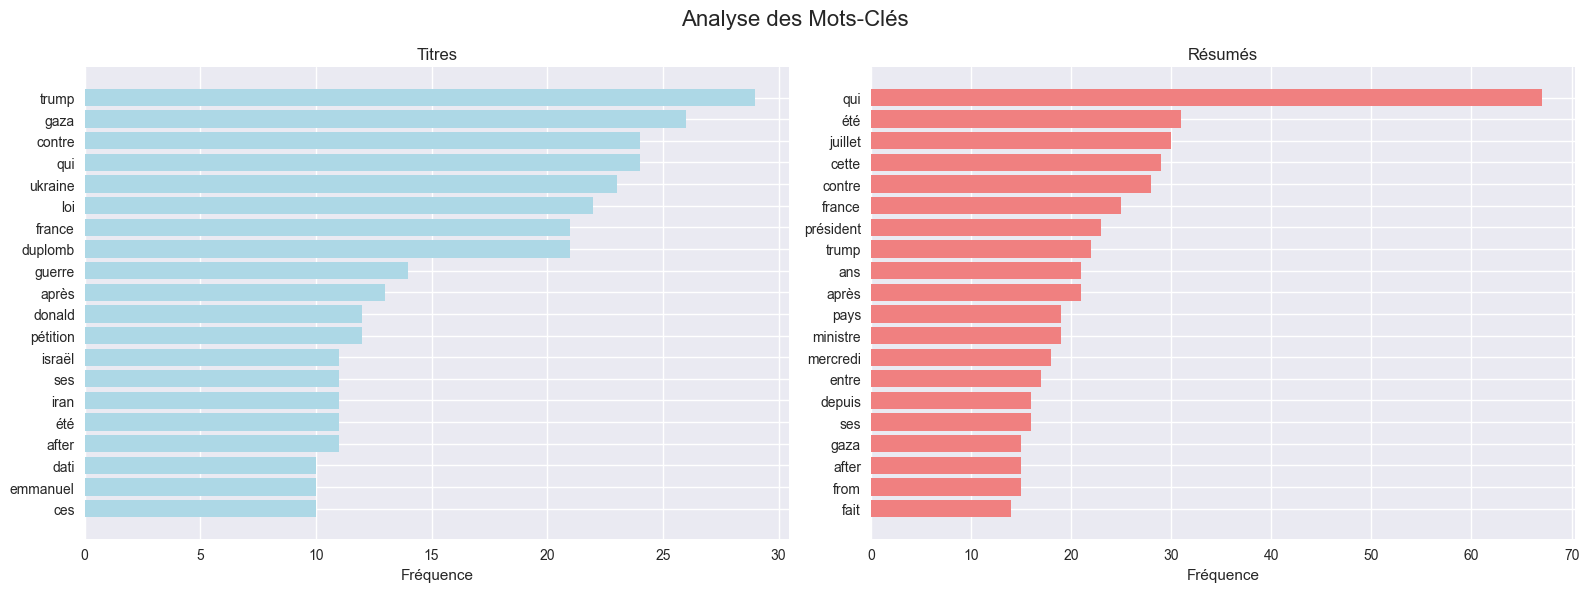

Insights textuels:
   • Mots uniques titres    : 2201
   • Mots uniques résumés   : 3628
   • Diversité lexicale titres : 0.639

Top 5 titres :
   • trump : 29
   • gaza : 26
   • contre : 24
   • qui : 24
   • ukraine : 23

Top 5 résumés :
   • qui : 67
   • été : 31
   • juillet : 30
   • cette : 29
   • contre : 28

Diversité des sources :
   • Source principale : https://www.nouvelobs.com/rss.xml (131 articles)
   • Répartition       : {'https://www.nouvelobs.com/rss.xml': 33.2, 'https://www.lexpress.fr/rss/actualite.xml': 25.1, 'https://rss.nytimes.com/services/xml/rss/nyt/World.xml': 13.9, 'https://www.euronews.com/rss?level=theme&name=news': 8.1, 'https://www.rfi.fr/fr/rss': 6.1, 'https://www.huffingtonpost.fr/feeds/index.xml': 5.1, 'https://www.lemonde.fr/rss/une.xml': 4.6, 'https://www.france24.com/fr/rss': 4.1}


In [20]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Analyse des mots-clés et thèmes
if not df.empty and df["title"].notna().sum() > 0 and df["summary"].notna().sum() > 0:

    # Préparation des données textuelles
    all_titles = ' '.join(df['title'].fillna('').str.lower())
    all_summaries = ' '.join(df['summary'].fillna('').str.lower())

    # Stop words FR + EN (liste simple, à enrichir au besoin)
    stop_words = {
        'le', 'de', 'et', 'à', 'un', 'il', 'être', 'en', 'avoir', 'que', 'pour',
        'dans', 'ce', 'son', 'une', 'sur', 'avec', 'ne', 'se', 'pas', 'tout', 'plus',
        'par', 'grand', 'comme', 'mais', 'faire', 'du', 'sa', 'les',
        'des', 'la', 'au', 'aux', 'nous', 'vous', 'ils', 'elle', 'sont', 'ont', 'est',
        'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with',
        'by', 'an', 'a', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had'
    }

    # Extraction des mots des titres
    title_words = re.findall(r'\b[a-zA-Zàâäéèêëïîôöùûüç]{3,}\b', all_titles)
    title_words = [word for word in title_words if word not in stop_words]
    title_word_freq = Counter(title_words).most_common(20)

    # Extraction des mots des résumés
    summary_words = re.findall(r'\b[a-zA-Zàâäéèêëïîôöùûüç]{3,}\b', all_summaries)
    summary_words = [word for word in summary_words if word not in stop_words]
    summary_word_freq = Counter(summary_words).most_common(20)

    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Analyse des Mots-Clés', fontsize=16)

    if title_word_freq:
        words, counts = zip(*title_word_freq)
        axes[0].barh(range(len(words)), counts, color='lightblue')
        axes[0].set_yticks(range(len(words)))
        axes[0].set_yticklabels(words)
        axes[0].set_xlabel('Fréquence')
        axes[0].set_title('Titres')
        axes[0].invert_yaxis()

    if summary_word_freq:
        words, counts = zip(*summary_word_freq)
        axes[1].barh(range(len(words)), counts, color='lightcoral')
        axes[1].set_yticks(range(len(words)))
        axes[1].set_yticklabels(words)
        axes[1].set_xlabel('Fréquence')
        axes[1].set_title('Résumés')
        axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Statistiques textuelles
    print("Insights textuels:")
    print(f"   • Mots uniques titres    : {len(set(title_words))}")
    print(f"   • Mots uniques résumés   : {len(set(summary_words))}")
    if len(title_words) > 0:
        print(f"   • Diversité lexicale titres : {len(set(title_words)) / len(title_words):.3f}")
    else:
        print("   • Diversité lexicale titres : N/A")

    # Top mots
    print("\nTop 5 titres :")
    for word, count in title_word_freq[:5]:
        print(f"   • {word} : {count}")

    print("\nTop 5 résumés :")
    for word, count in summary_word_freq[:5]:
        print(f"   • {word} : {count}")

    # Sources
    source_counts = df['source'].value_counts()
    if not source_counts.empty:
        print("\nDiversité des sources :")
        print(f"   • Source principale : {source_counts.index[0]} ({source_counts.iloc[0]} articles)")
        print(f"   • Répartition       : {(source_counts / len(df) * 100).round(1).to_dict()}")

else:
    print("Pas de données suffisantes pour l'analyse textuelle.")


## 6. Analyse des mots-clés et contenus

Analyse textuelle pour identifier les thèmes et mots-clés dominants.

In [23]:
# Visualisations interactives améliorées avec Plotly
if not df.empty:
    
    # 1. Graphique scatter interactif: longueur texte vs titre
    fig1 = px.scatter(
        df, 
        x='text_length', 
        y='title_length',
        color='source',
        size='reading_time',
        hover_data=['title', 'words_count'],
        title='Relation Longueur Texte vs Longueur Titre (par source)',
        labels={
            'text_length': 'Longueur du texte (caractères)',
            'title_length': 'Longueur du titre (caractères)',
            'source': 'Source RSS'
        }
    )
    fig1.update_layout(
        height=500,
        showlegend=True,
        legend=dict(orientation="v", yanchor="top", y=1, xanchor="left", x=1.02)
    )
    fig1.show()
    
    # 2. Graphique temporel conditionnel
    has_valid_dates = df["published"].notna().sum() > 10
    has_hour_data = df["published_hour"].notna().sum() > 0
    has_weekday_data = df["published_weekday"].notna().sum() > 0
    
    if has_valid_dates:
        # Agrégation par jour
        daily_stats = df.groupby(df['published'].dt.date).agg({
            'title': 'count',
            'text_length': 'mean',
            'reading_time': 'mean',
            'source': lambda x: x.nunique()
        }).rename(columns={
            'title': 'articles_count',
            'text_length': 'avg_length',
            'reading_time': 'avg_reading_time',
            'source': 'unique_sources'
        })
        
        fig2 = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Articles par jour', 'Longueur moyenne', 
                          'Temps de lecture moyen', 'Sources uniques par jour'),
            vertical_spacing=0.12,
            horizontal_spacing=0.1
        )
        
        # Articles par jour
        fig2.add_trace(
            go.Scatter(x=daily_stats.index, y=daily_stats['articles_count'],
                      mode='lines+markers', name='Articles/jour', line=dict(color='blue')),
            row=1, col=1
        )
        
        # Longueur moyenne
        fig2.add_trace(
            go.Scatter(x=daily_stats.index, y=daily_stats['avg_length'],
                      mode='lines+markers', name='Longueur moy.', line=dict(color='green')),
            row=1, col=2
        )
        
        # Temps de lecture moyen
        fig2.add_trace(
            go.Scatter(x=daily_stats.index, y=daily_stats['avg_reading_time'],
                      mode='lines+markers', name='Temps lecture', line=dict(color='red')),
            row=2, col=1
        )
        
        # Sources uniques
        fig2.add_trace(
            go.Bar(x=daily_stats.index, y=daily_stats['unique_sources'],
                   name='Sources uniques', marker_color='orange'),
            row=2, col=2
        )
        
        fig2.update_layout(
            height=600,
            title_text=" Évolution Temporelle des Métriques",
            showlegend=False
        )
        fig2.show()
    else:
        print(" Pas assez de données temporelles valides pour l'analyse temporelle")
        
        # Graphique alternatif: distribution par longueur de texte
        fig2_alt = px.histogram(
            df, 
            x='text_length', 
            color='source',
            nbins=30,
            title=" Distribution des Longueurs de Texte par Source",
            labels={'text_length': 'Longueur du texte (caractères)', 'count': 'Nombre d\'articles'}
        )
        fig2_alt.update_layout(height=500, bargap=0.1)
        fig2_alt.show()
    
    # 3. Distribution des sources (graphique en secteurs interactif)
    source_counts = df['source'].value_counts()
    fig3 = px.pie(
        values=source_counts.values,
        names=[name.split('/')[-1].replace('.xml', '').replace('.rss', '') for name in source_counts.index],
        title=' Distribution des Articles par Source RSS',
        labels={'values': 'Nombre d\'articles'}
    )
    fig3.update_traces(
        textposition='inside', 
        textinfo='percent+label',
        hovertemplate='<b>%{label}</b><br>Articles: %{value}<br>Pourcentage: %{percent}<extra></extra>'
    )
    fig3.update_layout(height=500, showlegend=True)
    fig3.show()
    
    # 4. Heatmap conditionnelle des publications
    if has_hour_data and has_weekday_data:
        heatmap_data = df.groupby(['published_weekday', 'published_hour']).size().reset_index(name='count')
        heatmap_pivot = heatmap_data.pivot(index='published_weekday', 
                                         columns='published_hour', 
                                         values='count').fillna(0)
        
        # Réorganiser les jours de la semaine
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                        'Friday', 'Saturday', 'Sunday']
        heatmap_pivot = heatmap_pivot.reindex(weekday_order, fill_value=0)
        
        fig4 = px.imshow(
            heatmap_pivot,
            labels=dict(x="Heure", y="Jour", color="Articles"),
            title=" Heatmap: Publications par Jour et Heure",
            color_continuous_scale="Viridis"
        )
        fig4.update_layout(height=400)
        fig4.show()
    else:
        print(" Pas de données d'heure/jour pour la heatmap")
        
        # Graphique alternatif: Top mots-clés
        if 'title_word_freq' in locals() and title_word_freq:
            words, counts = zip(*title_word_freq[:15])
            fig4_alt = px.bar(
                x=counts, 
                y=words, 
                orientation='h',
                title=" Top 15 des Mots-Clés dans les Titres",
                labels={'x': 'Fréquence', 'y': 'Mots-clés'}
            )
            fig4_alt.update_layout(height=500, yaxis={'categoryorder':'total ascending'})
            fig4_alt.show()
        else:
            # Graphique de distribution des temps de lecture
            fig4_alt = px.box(
                df, 
                x='source', 
                y='reading_time',
                title=" Distribution des Temps de Lecture par Source",
                labels={'reading_time': 'Temps de lecture (minutes)', 'source': 'Source'}
            )
            fig4_alt.update_xaxes(tickangle=45)
            fig4_alt.update_layout(height=500)
            fig4_alt.show()
    
    # 5. Graphique bonus: Analyse de la qualité du contenu
    df['content_category'] = pd.cut(df['text_length'], 
                                   bins=[0, 500, 1500, 3000, float('inf')], 
                                   labels=['Court', 'Moyen', 'Long', 'Très long'])
    
    fig5 = px.sunburst(
        df, 
        path=['source', 'content_category'], 
        title=" Répartition de la Qualité du Contenu par Source",
        color='reading_time',
        color_continuous_scale='RdYlBu'
    )
    fig5.update_layout(height=500)
    fig5.show()
    
    print(" Toutes les visualisations interactives ont été générées!")
    
    # Résumé des graphiques générés
    print("\n Graphiques générés:")
    print("   • Scatter plot: Longueur texte vs titre")
    print(f"   • Évolution temporelle: {'✅' if has_valid_dates else '❌ (remplacé par distribution)'}")
    print("   • Camembert: Distribution par source") 
    print(f"   • Heatmap temporelle: {'✅' if has_hour_data and has_weekday_data else '❌ (remplacé par analyse alternative)'}")
    print("   • Sunburst: Qualité du contenu par source")
    
else:
    print(" Pas de données pour les visualisations interactives")

 Pas assez de données temporelles valides pour l'analyse temporelle


 Pas de données d'heure/jour pour la heatmap


 Toutes les visualisations interactives ont été générées!

 Graphiques générés:
   • Scatter plot: Longueur texte vs titre
   • Évolution temporelle: ❌ (remplacé par distribution)
   • Camembert: Distribution par source
   • Heatmap temporelle: ❌ (remplacé par analyse alternative)
   • Sunburst: Qualité du contenu par source


## 8. Métriques de qualité

Évaluation de la performance du système de collecte et de la qualité des données.

In [22]:
# Rapport complet des métriques de qualité
print("RAPPORT DE QUALITÉ - INSIGHTDETECTOR")
print("=" * 50)

# Métriques de collecte
if 'metrics' in locals():
    print("\\n MÉTRIQUES DE COLLECTE:")
    success_rate = (metrics['total_inserted'] / max(metrics['total_fetched'], 1)) * 100
    print(f"   • Taux de succès global: {success_rate:.1f}%")
    print(f"   • Articles récupérés: {metrics['total_fetched']}")
    print(f"   • Articles traités: {metrics['total_processed']}")  
    print(f"   • Articles insérés: {metrics['total_inserted']}")
    print(f"   • Doublons détectés: {metrics['total_duplicates']}")
    print(f"   • Erreurs rencontrées: {len(metrics['processing_errors'])}")
    
    # Performance par source
    if metrics['sources_success']:
        print(f"\\n PERFORMANCE PAR SOURCE:")
        total_by_source = metrics['sources_success']
        for source, count in sorted(total_by_source.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / metrics['total_fetched']) * 100
            print(f"   • {source[:30]:<30} : {count:>3} articles ({percentage:>5.1f}%)")

# Métriques de qualité des données
if not df.empty:
    print(f"\\n QUALITÉ DES DONNÉES:")
    
    # Complétude des données
    completeness = {
        'Titre': df['title'].notna().sum() / len(df),
        'URL': df['url'].notna().sum() / len(df),
        'Résumé': df['summary'].notna().sum() / len(df),
        'Texte': df['text'].notna().sum() / len(df),
        'Date publication': df['published'].notna().sum() / len(df),
        'Source': df['source'].notna().sum() / len(df)
    }
    
    for field, completeness_rate in completeness.items():
        status = "✅" if completeness_rate > 0.9 else "⚠️ " if completeness_rate > 0.7 else "❌"
        print(f"   • {field:<15}: {completeness_rate:>6.1%} {status}")
    
    # Qualité du contenu
    print(f"\\n QUALITÉ DU CONTENU:")
    short_articles = (df['text_length'] < 500).sum()
    medium_articles = ((df['text_length'] >= 500) & (df['text_length'] < 2000)).sum()
    long_articles = (df['text_length'] >= 2000).sum()
    
    print(f"   • Articles courts (<500 char): {short_articles} ({short_articles/len(df)*100:.1f}%)")
    print(f"   • Articles moyens (500-2000): {medium_articles} ({medium_articles/len(df)*100:.1f}%)")
    print(f"   • Articles longs (>2000 char): {long_articles} ({long_articles/len(df)*100:.1f}%)")
    
    # Diversité temporelle
    if df['published'].notna().sum() > 0:
        date_range = (df['published'].max() - df['published'].min()).days
        unique_days = df['published'].dt.date.nunique()
        print(f"\\n COUVERTURE TEMPORELLE:")
        print(f"   • Période analysée: {date_range} jours")
        print(f"   • Jours avec publications: {unique_days}")
        print(f"   • Couverture temporelle: {unique_days/max(date_range, 1)*100:.1f}%")
    
    # Analyse des anomalies
    print(f"\\n DÉTECTION D'ANOMALIES:")
    
    # Articles avec titre très long/court
    very_short_titles = (df['title_length'] < 20).sum()
    very_long_titles = (df['title_length'] > 150).sum()
    print(f"   • Titres très courts (<20 char): {very_short_titles}")
    print(f"   • Titres très longs (>150 char): {very_long_titles}")
    
    # URLs potentiellement problématiques
    duplicate_urls = df['url'].duplicated().sum()
    print(f"   • URLs dupliquées: {duplicate_urls}")
    
    # Contenu potentiellement vide ou invalide
    empty_content = ((df['text'].str.len() < 100) | (df['text'].isna())).sum()
    print(f"   • Contenu vide/invalide: {empty_content}")

# Score de qualité global
if not df.empty and 'metrics' in locals():
    print(f"\\n SCORE DE QUALITÉ GLOBAL:")
    
    # Calcul du score (sur 100)
    collection_score = min(success_rate, 100) * 0.3  # 30% pour la collecte
    completeness_score = (sum(completeness.values()) / len(completeness)) * 100 * 0.4  # 40% pour la complétude
    content_score = ((medium_articles + long_articles) / len(df)) * 100 * 0.3  # 30% pour la qualité du contenu
    
    total_score = collection_score + completeness_score + content_score
    
    print(f"   • Score de collecte: {collection_score:.1f}/30")
    print(f"   • Score de complétude: {completeness_score:.1f}/40") 
    print(f"   • Score de contenu: {content_score:.1f}/30")
    print(f"   • SCORE TOTAL: {total_score:.1f}/100")
    
    # Recommandations
    print(f"\\n RECOMMANDATIONS:")
    if total_score >= 80:
        print("    Excellente qualité des données!")
    elif total_score >= 60:
        print("     Qualité correcte, quelques améliorations possibles:")
        if success_rate < 80:
            print("      - Améliorer le taux de succès de collecte")
        if completeness_score < 35:
            print("      - Améliorer la complétude des champs")
        if content_score < 25:
            print("      - Filtrer davantage le contenu de faible qualité")
    else:
        print("    Qualité insuffisante, actions requises:")
        print("      - Revoir la configuration des sources RSS")
        print("      - Améliorer les filtres de qualité")
        print("      - Corriger les erreurs de traitement")

print("\\n" + "=" * 50)

RAPPORT DE QUALITÉ - INSIGHTDETECTOR
\n MÉTRIQUES DE COLLECTE:
   • Taux de succès global: 77.5%
   • Articles récupérés: 510
   • Articles traités: 395
   • Articles insérés: 395
   • Doublons détectés: 0
   • Erreurs rencontrées: 0
\n PERFORMANCE PAR SOURCE:
   • https://www.nouvelobs.com/rss. : 200 articles ( 39.2%)
   • https://www.lexpress.fr/rss/ac : 100 articles ( 19.6%)
   • https://rss.nytimes.com/servic :  55 articles ( 10.8%)
   • https://www.euronews.com/rss?l :  50 articles (  9.8%)
   • https://www.rfi.fr/fr/rss      :  24 articles (  4.7%)
   • https://www.france24.com/fr/rs :  23 articles (  4.5%)
   • https://www.courrierinternatio :  20 articles (  3.9%)
   • https://www.huffingtonpost.fr/ :  20 articles (  3.9%)
   • https://www.lemonde.fr/rss/une :  18 articles (  3.5%)
\n QUALITÉ DES DONNÉES:
   • Titre          : 100.0% ✅
   • URL            : 100.0% ✅
   • Résumé         : 100.0% ✅
   • Texte          : 100.0% ✅
   • Date publication:   0.0% ❌
   • Source        

## 9. Conclusions et recommandations

Synthèse des insights découverts et recommandations pour améliorer le système.

In [25]:
# Nettoyage des ressources et conclusion
try:
    if session:
        session.close()
        logger.info("Session de base de données fermée")
    
    # Résumé final pour l'utilisateur
    if not df.empty and 'metrics' in locals():
        print("\\n ANALYSE TERMINÉE AVEC SUCCÈS!")
        print(f" {len(df)} articles analysés de {df['source'].nunique()} sources différentes")
        print(f" Période couverte: {(df['published'].max() - df['published'].min()).days} jours")
        print(f" Taux de réussite: {(metrics['total_inserted']/metrics['total_fetched']*100):.1f}%")
        
        # Insights clés découverts
        print(f"\\n INSIGHTS CLÉS:")
        if df['published_hour'].notna().sum() > 0:
            peak_hour = df['published_hour'].mode().iloc[0]
            print(f"   • Heure de pointe: {peak_hour}h")
        
        top_source = df['source'].mode().iloc[0]
        top_source_count = df['source'].value_counts().iloc[0]
        print(f"   • Source la plus productive: {top_source} ({top_source_count} articles)")
        
        avg_length = df['text_length'].mean()
        print(f"   • Longueur moyenne des articles: {avg_length:.0f} caractères")
        
        avg_reading = df['reading_time'].mean()
        print(f"   • Temps de lecture moyen: {avg_reading:.1f} minutes")
    
    print("\\n Toutes les analyses sont complètes. Le notebook peut être utilisé pour:")
    print("   • Surveiller la qualité de la collecte RSS")
    print("   • Identifier les tendances temporelles de publication") 
    print("   • Analyser les performances par source")
    print("   • Détecter les anomalies dans les données")
    print("   • Optimiser la configuration des flux RSS")
    
except Exception as e:
    logger.error(f"Erreur lors du nettoyage: {e}")
    
finally:
    print("\\n Analyse RSS terminée.")

2025-07-23 20:18:04,095 - INFO - Session de base de données fermée


\n ANALYSE TERMINÉE AVEC SUCCÈS!
 395 articles analysés de 8 sources différentes
 Période couverte: nan jours
 Taux de réussite: 77.5%
\n INSIGHTS CLÉS:
   • Source la plus productive: https://www.nouvelobs.com/rss.xml (131 articles)
   • Longueur moyenne des articles: 3413 caractères
   • Temps de lecture moyen: 2.2 minutes
\n Toutes les analyses sont complètes. Le notebook peut être utilisé pour:
   • Surveiller la qualité de la collecte RSS
   • Identifier les tendances temporelles de publication
   • Analyser les performances par source
   • Détecter les anomalies dans les données
   • Optimiser la configuration des flux RSS
\n Analyse RSS terminée.


In [ ]:
# Copyright 2025 beedi.goua_square-ma
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

